# ON/OFF theta2 and alpha plot

This notebook produces both the theta2 plot and the alpha plot of a set of DL2 files.

It extracts automatically also the time duration, given a set of DL2 files merged run-wise.

Input:
- merged DL2 run files (run-wise)
- merged ON and merged all DL2 files
- run numbers
- selection cuts


In [10]:
__authors__ =  'Ruben Lopez, Luca Foffano' #  ruben.lopezcoto@pd.infn.it, luca.foffano@unige.ch
__version__ = '3.08.2020'


import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
warnings.filterwarnings("ignore",category=FutureWarning)
warnings.filterwarnings("ignore",category=RuntimeWarning)

import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from lstchain.reco.utils import reco_source_position_sky, radec_to_camera

from lstchain.tests.test_lstchain import dl2_file, dl2_params_lstcam_key
from astropy.coordinates import SkyCoord
import astropy.units as u
from gammapy.stats import WStatCountsStatistic



plt.rcParams['figure.figsize'] = (12, 12)
plt.rcParams['font.size'] = 20

######################################################################################

# SELECTION CUTS

intensity_cut = 200
leakage_cut = 0.2
wl_cut = 0.01  
gammaness_cut = 0.9
n_pixels_cut = 1800    # 1800
r_cut = 1

theta2_cut =  0.1

alpha_cut = 8.  


# ON and OFF data files (each one obtained merging all ON or OFF files)

on_data_file = '../data/crab_on_off/crab_on_src_dep/dl2_Run01874_merged.h5'

off_data_file = '../data/crab_on_off/crab_off_src_dep/dl2_Run01881_merged.h5' 

# reads files - takes some minutes
on_data = pd.read_hdf(on_data_file, key=dl2_params_lstcam_key)
off_data = pd.read_hdf(off_data_file, key=dl2_params_lstcam_key)

In [11]:
# run duration estimation

print("Evaluating run duration...\n")

on_obstime_start = pd.to_datetime(on_data['dragon_time'][0], unit='s')
on_obstime_end = pd.to_datetime(on_data['dragon_time'][len(on_data)-1], unit='s')
print("duration: {:.1f} min".format((on_obstime_end - on_obstime_start).total_seconds()/60)  )
total_obs_duration_on = (on_obstime_end - on_obstime_start).total_seconds()

print("ON data total duration: {:.1f} s  =  {:.1f} min\n".format(total_obs_duration_on, 
                                                                 total_obs_duration_on/60))


#####################################

off_obstime_start = pd.to_datetime(off_data['dragon_time'][0], unit='s')
off_obstime_end = pd.to_datetime(off_data['dragon_time'][len(off_data)-1], unit='s')
print("duration: {:.1f} min".format((off_obstime_end - off_obstime_start).total_seconds()/60)  )
total_obs_duration_off = (off_obstime_end - off_obstime_start).total_seconds()


print("OFF data total duration: {:.1f} s  =  {:.1f} min\n".format(total_obs_duration_off, 
                                                                 total_obs_duration_off/60))



Evaluating run duration...

duration: 20.1 min
ON data total duration: 1203.6 s  =  20.1 min

duration: 20.3 min
OFF data total duration: 1218.3 s  =  20.3 min



# Alpha analysis

In this section, we compute the alpha plot 

In [12]:
# ON selection

selection_cuts_on_data = np.array([
                    (on_data['leakage_intensity_width_2'] < leakage_cut) 
                    & (on_data['intensity'] > intensity_cut) 
                    & (on_data['n_pixels'] < n_pixels_cut)
                    & (on_data['wl'] > wl_cut) 
                    & (on_data['gammaness'] > gammaness_cut)
                    & (on_data['r'] < r_cut) 
                    ])[0]

alpha_on = on_data.alpha[selection_cuts_on_data]

# OFF selection

selection_cuts_off_data = np.array([
                    (off_data['leakage_intensity_width_2'] < leakage_cut) 
                    & (off_data['intensity'] > intensity_cut) 
                    & (off_data['n_pixels'] < n_pixels_cut)
                    & (off_data['wl'] > wl_cut) 
                    & (off_data['gammaness'] > gammaness_cut)  
                    & (off_data['r'] < r_cut)
                    ])[0]

alpha_off = off_data.alpha[selection_cuts_off_data]


In [16]:
# normalization
norm_range_alpha_min = 20.
norm_range_alpha_max = 80.

Non_norm = np.sum((alpha_on > norm_range_alpha_min) & (alpha_on < norm_range_alpha_max))
Noff_norm = np.sum((alpha_off > norm_range_alpha_min) & (alpha_off < norm_range_alpha_max))

Norm_alpha = Non_norm / Noff_norm

Non = np.sum(alpha_on < alpha_cut)
Noff = np.sum(alpha_off < alpha_cut)
Nex = Non - Noff * Norm_alpha
S = Nex / (np.sqrt(Noff) * Norm_alpha)

print("Normalization alpha {:.2f}".format(Norm_alpha))

print("Non, Noff, Nex = {:.0f}, {:.0f}, {:.0f}".format(Non, Noff, Nex))

stat = WStatCountsStatistic(Non, Noff, Norm_alpha)
lima_significance = stat.sqrt_ts.item()

print("\nSignificance: {:.2f} sigma".format(S))
print("\nSignificance Li&Ma: {:.2f} sigma".format(lima_significance))

Normalization alpha 1.09
Non, Noff, Nex = 1089, 484, 560

Significance: 23.26 sigma

Significance Li&Ma: 13.70 sigma


/Users/rlopezcoto/opt/anaconda3/envs/lst/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  del sys.path[0]


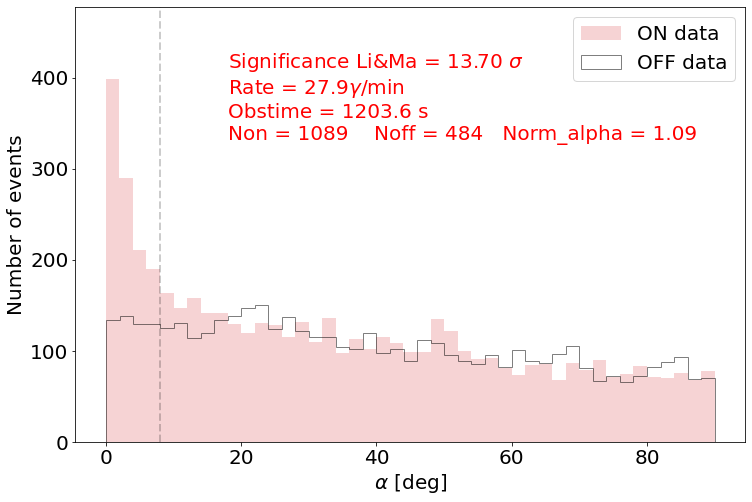

In [17]:
# alpha plot

nbins = 45

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
h_on = ax.hist(alpha_on, label = 'ON data', bins=nbins, alpha=0.2, color = 'C3')
h2 = ax.hist(alpha_off, weights = Norm_alpha * np.ones(len(alpha_off)),
            histtype='step', label = 'OFF data', bins=nbins, alpha=0.5, color = 'k')

ax.annotate(s=f'Significance Li&Ma = {lima_significance:.2f}' \
            f' $\sigma$\nRate = {Nex/total_obs_duration_on * 60:.1f}' \
            f'$\gamma$/min  \nObstime = {total_obs_duration_on:.1f} s\nNon = {Non}    Noff = {Noff}   Norm_alpha = {Norm_alpha:.2f}', 
           xy=(np.max(h_on[1]/5), np.max(h_on[0]/6*5)), size = 20, color = 'r')

ax.vlines(x = alpha_cut, ymin = 0, ymax = np.max(h_on[0]*1.2), linestyle='--', linewidth = 2, color = 'black', alpha = 0.2)

ax.set_ylabel(r'Number of events')
ax.set_ylim(0,np.max(h_on[0]*1.2))

ax.set_xlabel(r'$\alpha$ [deg]')
ax.legend()